## Prepare Data

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 2)

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
call_data = "../data/raw/call-center-data-v2-daily.csv"
df = pd.read_csv(call_data, parse_dates=["Date"])

In [15]:
# Convert time columns to total seconds
time_cols = ["Answer Speed (AVG)", "Talk Duration (AVG)", "Waiting Time (AVG)"]
for col in time_cols:
    df[col] = pd.to_timedelta(df[col]).dt.total_seconds()

In [16]:
# Set the Date column as the index
df.set_index("Date", inplace=True)

In [18]:
# Sort the index
df.sort_index(inplace=True)
print(df.head())
print("\n")
print(df.info())

            Incoming Calls  Answered Calls  Abandoned Calls  \
Date                                                          
2022-01-01             157             145               12   
2022-01-02              37              37                0   
2022-01-03             317             304               13   
2022-01-04             253             244                9   
2022-01-05             214             205                9   

            Answer Speed (AVG)  Talk Duration (AVG)  Waiting Time (AVG)  
Date                                                                     
2022-01-01                15.0                149.0               192.0  
2022-01-02                 3.0                126.0                35.0  
2022-01-03                18.0                 95.0               157.0  
2022-01-04                13.0                110.0               122.0  
2022-01-05                10.0                130.0               202.0  


<class 'pandas.core.frame.DataFrame'>


## Modeling (Baseline Model: Seasonal Naive Forecast)
the forecast for any given day is the value from the same day in the previous week.

In [19]:
from sklearn.metrics import mean_absolute_error

In [20]:
# 1. Split data chronologically
train = df[df.index < "2025-03-01"]
test = df[df.index >= "2025-03-01"]

In [22]:
# 2. Create the baseline forecast
test_dates = test.index
# We need the last 7 days of the training set to start the forecast
history = train["Incoming Calls"]

In [25]:
# Create predictions with Seasonal Naive (Weekly) - handle missing dates
predictions = []
actual_test_dates = []

for date in test_dates:
    # Find the date from 7 days ago
    last_week_date = date - pd.Timedelta(days=7)

    # Check if the date exists in the training data
    if last_week_date in history.index:
        prediction = history.loc[last_week_date]
        predictions.append(prediction)
        actual_test_dates.append(date)

# Create a series with the predictions for evaluation
predictions_series = pd.Series(predictions, index=actual_test_dates)
actual_values = test.loc[actual_test_dates, "Incoming Calls"]

print(f"Number of predictions made: {len(predictions)}")
print("Predictions (first 10):")
print(predictions_series.head(10))

Number of predictions made: 7
Predictions (first 10):
2025-03-01     85
2025-03-02     44
2025-03-03    393
2025-03-04    283
2025-03-05    241
2025-03-06    281
2025-03-07    298
dtype: int64


In [26]:
# 3. Evaluate the baseline model
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Calculate evaluation metrics
mae = mean_absolute_error(actual_values, predictions_series)
rmse = np.sqrt(mean_squared_error(actual_values, predictions_series))
mape = mean_absolute_percentage_error(actual_values, predictions_series)

print("Seasonal Naive (Weekly) Baseline Model - Evaluation Metrics")
print("=" * 55)
print(f"Mean Absolute Error (MAE):           {mae:.2f}")
print(f"Root Mean Squared Error (RMSE):      {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f} ({mape*100:.2f}%)")
print("=" * 55)

Seasonal Naive (Weekly) Baseline Model - Evaluation Metrics
Mean Absolute Error (MAE):           90.00
Root Mean Squared Error (RMSE):      111.61
Mean Absolute Percentage Error (MAPE): 0.4303 (43.03%)


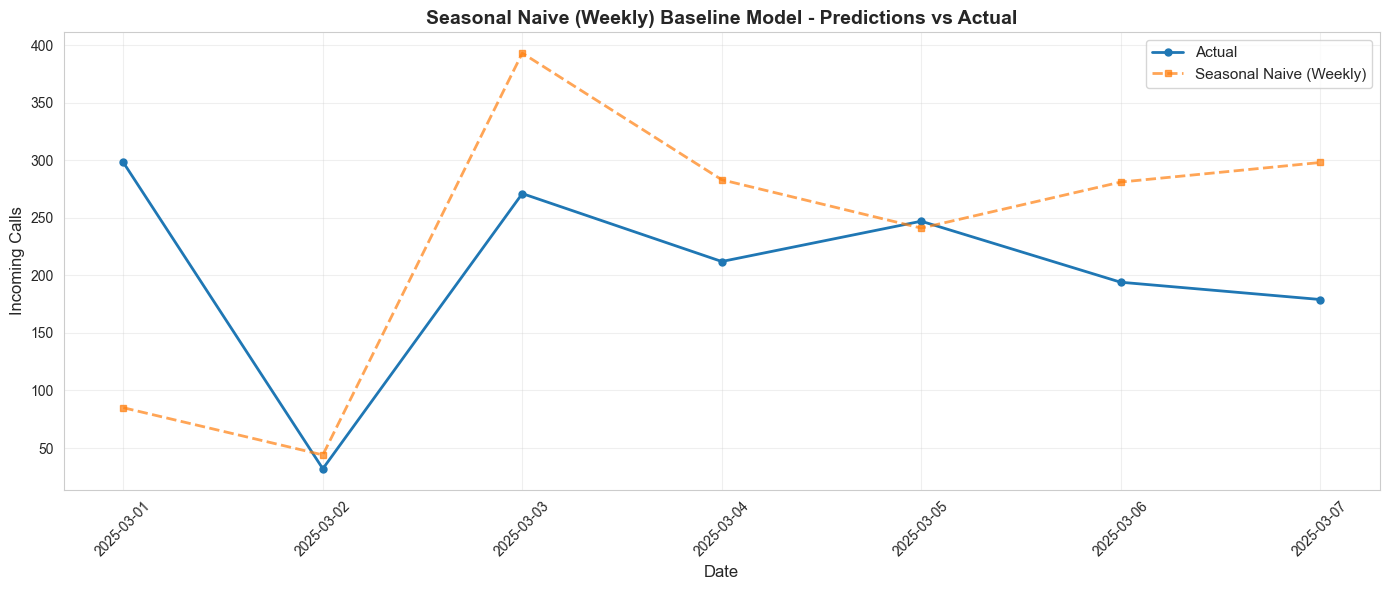


Prediction accuracy comparison:
Min calls: 32, Max calls: 298
Mean actual: 204.71, Mean predicted: 232.14


In [27]:
# 4. Visualize predictions vs actual values
plt.figure(figsize=(14, 6))

# Plot actual test values
plt.plot(actual_test_dates, actual_values, "o-", label="Actual", linewidth=2, markersize=5)

# Plot predictions
plt.plot(actual_test_dates, predictions_series, "s--", label="Seasonal Naive (Weekly)", linewidth=2, markersize=5, alpha=0.7)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Incoming Calls", fontsize=12)
plt.title("Seasonal Naive (Weekly) Baseline Model - Predictions vs Actual", fontsize=14, fontweight="bold")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nPrediction accuracy comparison:")
print(f"Min calls: {actual_values.min():.0f}, Max calls: {actual_values.max():.0f}")
print(f"Mean actual: {actual_values.mean():.2f}, Mean predicted: {predictions_series.mean():.2f}")